In [56]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
train_on_gpu = torch.cuda.is_available()

In [58]:
#num of subprocesses to use for data loading
num_workers = 0
batch_size = 20
#validation percentage
valid_size = 0.2

In [59]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(root = 'CIFAR10_data',
                             train=True,
                             download=True,
                             transform=transform)
test_data = datasets.CIFAR10(root = 'CIFAR10_data',
                             train=False,
                             download=True,
                             transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [60]:
#get indices for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [61]:
#define samplers for obtaining batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [62]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, 
                                           num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<h2><b>Visualise data</b></h2>

(3, 32, 32)


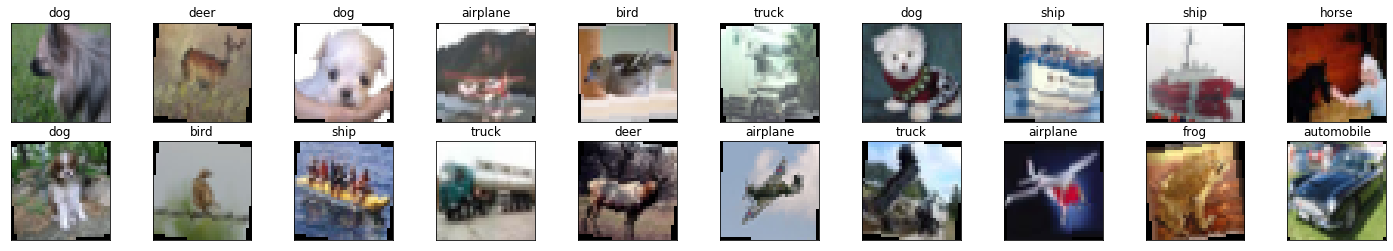

In [63]:
def imgshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images[0].shape)
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imgshow(images[idx])
    ax.set_title(classes[labels[idx]])

<h2><b>Define Architecture</b></h2>

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop = 0.2
        
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=16, 
            kernel_size=3, 
            padding=1)
        
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32, 
            kernel_size=3, 
            padding=1)
        
        self.conv3 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=3, 
            padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*4*4, 400)
        self.fc2 = nn.Linear(400, 62)
        
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        
        x = self.dropout(x)
        x = F.tanh(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = Net().cuda()
print(model)
        

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=62, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<h2><b>Specify Loss and Optimization Functions</b></h2>

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

<h2><b>(Optional)Load weights if you want to retrain model</b></h2>

In [31]:
model.load_state_dict(torch.load('model_CIFAR10_CNN.pt'))

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for conv1.weight: copying a param with shape torch.Size([16, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 3, 3, 3]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([400, 576]) from checkpoint, the shape in current model is torch.Size([400, 12544]).

<h2><b>Train Network</b></h2>


Steps:
<ul>
<li>Clear grads</li>
<li>Forward prop</li>
<li>Loss calc</li>
<li>Back prop</li>
<li>Optimization step</li>
<li>Update average training loss</li>
</ul>

In [67]:
epochs = 50
#init min validation loss
valid_loss_min = np.Inf

for epoch in range(epochs):
    batch_num=0

    train_loss = 0.0
    valid_loss = 0.0

    train_acc=0.0
    val_acc=0.0
    
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        batch_num+=1
    
    model.eval()
    for data, target in valid_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss+=loss.item()*data.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1,
        train_acc/batch_num * 100,
        val_acc/batch_num * 100
    ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_CIFAR10_CNN_Aug.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.938481 	Validation Loss: 1.611231
Epoch: 1 	Training Accuracy: 30.415000 	Validation Accuracy: 10.392500
Validation loss decreased (inf --> 1.611231).  Saving model ...
Epoch: 2 	Training Loss: 1.530168 	Validation Loss: 1.416892
Epoch: 2 	Training Accuracy: 44.305000 	Validation Accuracy: 12.282500
Validation loss decreased (1.611231 --> 1.416892).  Saving model ...
Epoch: 3 	Training Loss: 1.344866 	Validation Loss: 1.224340
Epoch: 3 	Training Accuracy: 51.512500 	Validation Accuracy: 14.097500
Validation loss decreased (1.416892 --> 1.224340).  Saving model ...
Epoch: 4 	Training Loss: 1.223211 	Validation Loss: 1.154252
Epoch: 4 	Training Accuracy: 56.385000 	Validation Accuracy: 14.900000
Validation loss decreased (1.224340 --> 1.154252).  Saving model ...
Epoch: 5 	Training Loss: 1.133395 	Validation Loss: 1.072691
Epoch: 5 	Training Accuracy: 59.860000 	Validation Accuracy: 15.402500
Validation loss decreased (1.154252 --> 1.072691).  Saving model ...


Epoch: 49 	Training Loss: 0.580719 	Validation Loss: 0.713587
Epoch: 49 	Training Accuracy: 79.417500 	Validation Accuracy: 18.917500
Epoch: 50 	Training Loss: 0.573986 	Validation Loss: 0.680050
Epoch: 50 	Training Accuracy: 79.527500 	Validation Accuracy: 19.067500


In [68]:
model.load_state_dict(torch.load('model_CIFAR10_CNN_Aug.pt'))

<All keys matched successfully>

<h2><b>Test the Trained Network</b></h2>

In [69]:
test_loss = 0.0
class_correct = list(0. for i in range (10))
class_total = list(0. for i in range (10))

model.eval()

for data, target in test_loader:
    data = data.cuda()
    target = target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    #compare pred to label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
      if (100*class_correct[i]/class_total[i] < 50):
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i) if i<10 else letters[i],
            100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i]))
        )
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. *np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total))
     )

Test Loss: 0.659262


Test Accuracy (Overall): 77% (7783/10000)


<h2><b>Visualize Sample test Results</b></h2>

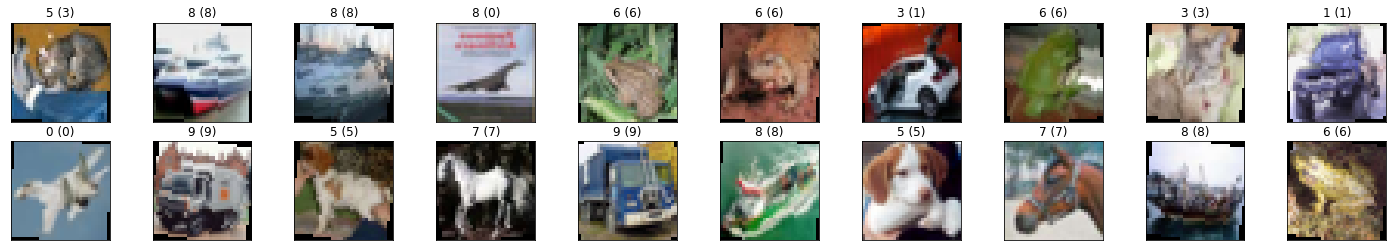

In [70]:
dataiter = iter(test_loader)
images , labels = dataiter.next()

images = images.cuda()
labels = labels.cuda()
output = model(images)
_, preds = torch.max(output, 1)
images = torch.Tensor.cpu(images).numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imgshow(images[idx])
    ax.set_title(classes[labels[idx]])
    ax.set_title("{} ({})".format(
        str(preds[idx].item()),
        str(labels[idx].item()), 
        color = ("green" if preds[idx] == labels[idx] else "red")))